In [1]:
# julia 1.1.1

function ComplexToRGB(A)
  lengthx,lengthy,lengthz,lengthf = size(A);
    ##### Color Phase
    angleDeg = 360
    maxHueInHSV = 330 # why 330 ?
    cm = linspace_(ColorTypes.HSV(0,1,1),ColorTypes.HSV(maxHueInHSV,1,1),angleDeg);
    cr=zeros(angleDeg);
    cg=zeros(angleDeg);
    cb=zeros(angleDeg);

    for i=1:angleDeg
      cr[i]=convert(RGB{Float64},cm[i]).r
      cg[i]=convert(RGB{Float64},cm[i]).g
      cb[i]=convert(RGB{Float64},cm[i]).b
    end

    knots=(linspace_(0,2*pi,angleDeg),);
    itpr = interpolate(knots,cr, Gridded(Linear()));
    itpg = interpolate(knots,cg, Gridded(Linear()));
    itpb = interpolate(knots,cb, Gridded(Linear()));

    # convert complex values to absolute value and phase into Color
    dataAbs = abs.(A);
    dataReal = real.(A);
    dataImag = imag.(A);

    minReal,maxReal = extrema(dataReal);
    minImag,maxImag = extrema(dataImag);

    dataAngle = angle.(A);
    dataAngle[dataAngle.<0]=dataAngle[dataAngle.<0].+2*pi; # why shift negative by 2pi, instead of everything by pi?

    dataC = zeros(Float64,lengthx,lengthy,lengthz, 3, lengthf);
    dataC[:,:,:,1,:]=dataAbs.*reshape(itpr.(dataAngle), lengthx, lengthy, lengthz, lengthf);
    dataC[:,:,:,2,:]=dataAbs.*reshape(itpg.(dataAngle), lengthx, lengthy, lengthz, lengthf);
    dataC[:,:,:,3,:]=dataAbs.*reshape(itpb.(dataAngle), lengthx, lengthy, lengthz, lengthf);

    minAbs,maxAbs = extrema(dataC);
   return dataC,minAbs,maxAbs
end


function RGBToComplex(dataRGB)
    lengthx,lengthy,lengthz,lengthc,lengthf = size(dataRGB);
    dataComplex = zeros(Complex{Float32},lengthx,lengthy,lengthz,lengthf)

    for k=1:lengthx
        for l=1:lengthy
            for m=1:lengthz
                for n=1:lengthf
                    rgb = ColorTypes.RGB(dataRGB[k,l,m,1,n],dataRGB[k,l,m,2,n],dataRGB[k,l,m,3,n])
                    hsv = convert(HSV,rgb);
                    dataComplex[k,l,m,n] = rectangularForm(hsv.v,hsv.h /330*2*pi)
                end
            end
        end
    end
    return dataComplex
end

function rectangularForm(absolueValue, angle)
    return absolueValue*cos(angle) + absolueValue*sin(angle)*im
end

function ComplexToComplex(dataRGB)
    lengthx,lengthy,lengthz,lengthc,lengthf = size(dataRGB);
    dataComplex = zeros(Complex{Float32},lengthx,lengthy,lengthz,lengthf)

    for k=1:lengthx
        for l=1:lengthy
            for m=1:lengthz
                for n=1:lengthf
                    dataComplex[k,l,m,n] = dataRGB[k,l,m,1,n] + dataRGB[k,l,m,2,n]*im 
                end
            end
        end
    end
    return dataComplex
end


ComplexToComplex (generic function with 1 method)

In [2]:
using MPILib, MPIReco,MPIFiles,PyPlot,HDF5,ImageMagick, Logging

io_log = open("log.txt", "w+")

IOStream(<file log.txt>)

In [3]:
#GT System Matrix Synomag
groundTruthSF = MPIFile("/opt/mpidata/20180228_180048_OpenMPIData_1_1/19")
freqs = filterFrequencies(groundTruthSF,minFreq=80e3,SNRThresh=3);

SGT,grid = getSF(groundTruthSF,freqs,bgcorrection=false,tfCorrection=false);
SGTReshaped = reshape(SGT,grid.shape...,:);

In [4]:
Synomag = h5read("/media/daisy3/Data/data_set/MPISystemMatrix/pre_processed/SynomagPEG_GT_SNR3_HR_3929x40x40x40x3_RGB.h5","/data");
Synomag_name = "SynomagGTPro"
MaskGT = Synomag.>0;
Synomag = Synomag.*MaskGT;
Synomag = permutedims(Synomag,[2,3,4,1,5]);
Synomag = RGBToComplex(Synomag[:,:,:,end:-1:1,:]);
Synomag = Synomag[3:end-1,3:end-1,3:end-1,:];
Synomag = reshape(Synomag,prod(grid.shape),:);

In [5]:
# System Matrix CNN

poisson8x = h5read("/media/daisy3/Data/fahadBackup/completeResults/Recovered_HR_SF_SynomagPEG/rgb_l1_poisson_8x/CNNPredict.h5","/data");
poisson8x_name = "rgb-poisson-8x-SynomagPEG"
MaskPoisson8x = poisson8x.>0;
poisson8x = poisson8x.*MaskPoisson8x;
poisson8x = permutedims(poisson8x,[2,3,4,1,5]);
poisson8x = RGBToComplex(poisson8x[:,:,:,end:-1:1,:]);
poisson8x = poisson8x[3:end-1,3:end-1,3:end-1,:];
poisson8x = reshape(poisson8x,prod(grid.shape),:);

poisson64x = h5read("/media/daisy3/Data/fahadBackup/completeResults/Recovered_HR_SF_SynomagPEG/rgb_l1_poisson_64x/CNNPredict.h5","/data");
poisson64x_name = "rgb-poisson-64x-SynomagPEG"
MaskPoisson64x = poisson64x.>0;
poisson64x = poisson64x.*MaskPoisson64x;
poisson64x = permutedims(poisson64x,[2,3,4,1,5]);
poisson64x = RGBToComplex(poisson64x[:,:,:,end:-1:1,:]);
poisson64x = poisson64x[3:end-1,3:end-1,3:end-1,:];
poisson64x = reshape(poisson64x,prod(grid.shape),:);

equi8x = h5read("/media/daisy3/Data/fahadBackup/completeResults/Recovered_HR_SF_SynomagPEG/rgb_l1_equi_8x/CNNPredict.h5","/data");
equi8x_name = "rgb-equi-8x-SynomagPEG"
MaskEqui8x = equi8x.>0;
equi8x = equi8x.*MaskEqui8x;
equi8x = permutedims(equi8x,[2,3,4,1,5]);
equi8x = RGBToComplex(equi8x[:,:,:,end:-1:1,:]);
equi8x = equi8x[3:end-1,3:end-1,3:end-1,:];
equi8x = reshape(equi8x,prod(grid.shape),:);

equi64x = h5read("/media/daisy3/Data/fahadBackup/completeResults/Recovered_HR_SF_SynomagPEG/rgb_l1_equi_64x/CNNPredict.h5","/data");
equi64x_name = "rgb-equi-64x-SynomagPEG"
MaskEqui64x = equi64x.>0;
equi64x = equi64x.*MaskEqui64x;
equi64x =permutedims(equi64x,[2,3,4,1,5]);
equi64x = RGBToComplex(equi64x[:,:,:,end:-1:1,:]);
equi64x =equi64x[3:end-1,3:end-1,3:end-1,:];
equi64x = reshape(equi64x,prod(grid.shape),:);

In [6]:
function nrmse(I, Ireco; alpha=(dot(vec(Ireco),vec(I))) / (dot(vec(Ireco),vec(Ireco))))
  N = length(I)
  # This is a little trick. We usually are not interested in simple scalings
  # and therefore "calibrate" them away
  I2 = Ireco.*alpha
  RMS =  1.0/sqrt(N)*norm(vec(I)-vec(I2))
  NRMS = RMS/(maximum(abs.(I))-minimum(abs.(I)))
  return NRMS, I2
end

nrmse (generic function with 1 method)

In [7]:
names = [equi8x_name,equi64x_name,poisson8x_name,poisson64x_name,Synomag_name]
SCNNs = [equi8x,equi64x,poisson8x,poisson64x,Synomag]

over5CNN = []
nrmseS = []
for l=1:length(names)
    @info "Processing $(names[l])"
    write(io_log, "Processing $(names[l])\n")
    
    nrmseStmp = zeros(length(freqs))
    for k=1:length(freqs)
        nrmseStmp[k],  = nrmse(SGT[:,k],SCNNs[l][:,k]);
        if isnan(nrmseStmp[k])
            nrmseStmp[k] = 1
            println("NAN found:",k)
       end
    end
    push!(nrmseS, nrmseStmp)
   
    @info "Mean NRMSE: ", mean(nrmseStmp)
    write(io_log, "Mean NRMSE: $(mean(nrmseStmp))\n")

    over5CNN=findall(x->x<=0.05,nrmseStmp)
    @info "Num freqs with error below 5%: ",length(over5CNN)," percentage: ",length(over5CNN)/length(freqs)*100,"%"
    write(io_log, "Num freqs with error below 5%: $(length(over5CNN)) percentage: $(length(over5CNN)/length(freqs)*100)%)\n")
end

┌ Info: Processing rgb-equi-8x-SynomagPEG
└ @ Main In[7]:7
┌ Info: ("Mean NRMSE: ", 0.034657439953732924)
└ @ Main In[7]:20
┌ Info: ("Num freqs with error below 5%: ", 3016, " percentage: ", 76.76253499618223, "%")
└ @ Main In[7]:24
┌ Info: Processing rgb-equi-64x-SynomagPEG
└ @ Main In[7]:7
┌ Info: ("Mean NRMSE: ", 0.0409831125233422)
└ @ Main In[7]:20
┌ Info: ("Num freqs with error below 5%: ", 2702, " percentage: ", 68.77067956222957, "%")
└ @ Main In[7]:24
┌ Info: Processing rgb-poisson-8x-SynomagPEG
└ @ Main In[7]:7
┌ Info: ("Mean NRMSE: ", 0.10199003180488374)
└ @ Main In[7]:20
┌ Info: ("Num freqs with error below 5%: ", 513, " percentage: ", 13.056757444642402, "%")
└ @ Main In[7]:24
┌ Info: Processing rgb-poisson-64x-SynomagPEG
└ @ Main In[7]:7
┌ Info: ("Mean NRMSE: ", 0.06312379718642502)
└ @ Main In[7]:20
┌ Info: ("Num freqs with error below 5%: ", 1780, " percentage: ", 45.30414863833037, "%")
└ @ Main In[7]:24
┌ Info: Processing SynomagGTPro
└ @ Main In[7]:7
┌ Info: ("Mean 

In [8]:
SNR = MPILib.getSNRAllFrequencies(groundTruthSF);

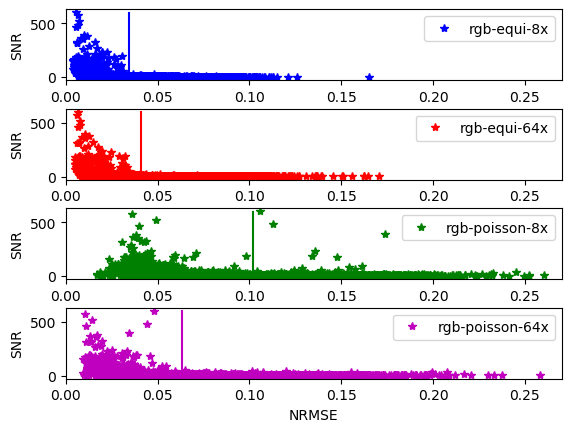

In [9]:
names2 = ["rgb-equi-8x","rgb-equi-64x","rgb-poisson-8x","rgb-poisson-64x"]

colL = ["b","r","g","m","c","k"]
col = ["b*","r*","g*","m*","c*","k*"]
for i=1:4
    figure(1)
    subplot(4,1,i)
    subplots_adjust(hspace=0.4)
    plot(mean(nrmseS[i])*ones(600),collect(1:600),colL[i])
    plot(nrmseS[i],SNR[freqs],col[i],label=names2[i])
    #plot(nrmseS[i][vcat(1,138,200)],SNR[freqs[vcat(1,138,200)]],"yo")
    xlim((0 ,0.27))
    legend(),xlabel("NRMSE"),ylabel("SNR")
end

savefig("errorSynoRGB.pdf")

In [ ]:
# image SF
f =  1001:1500
#rgb-equi-64x-SynomagPEG

for k in f
    figure(2)
    subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    ax = imshow(abs.(
            [
                reshape(Synomag[:,k],37,37,37)[:,:,19];
                reshape(SCNNs[1][:,k],37,37,37)[:,:,19];
                reshape(SCNNs[2][:,k],37,37,37)[:,:,19];
                reshape(SCNNs[3][:,k],37,37,37)[:,:,19];
                reshape(SCNNs[4][:,k],37,37,37)[:,:,19];
                ]),cmap="gray",)
    gca().set_axis_off()
    margins(0,0)
    
    savefig("imagesSF/GT_$k.pdf",bbox_inches="tight",pad_inches=0)
end